In [1]:
!pip install wheel==0.37.1 setuptools==59.6.0
!pip install gym[atari,accept-rom-license]==0.21.0 tensorflow-probability==0.19.0 tqdm==4.64.1

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
from typing import List, Callable, Union, Iterable, Any, Tuple
from dataclasses import dataclass, field

import gym
import numpy as np
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from keras import Model, Input
from keras.layers import \
    Dense, Conv2D, Conv2DTranspose, Dropout, Flatten, \
    Reshape, Lambda, Concatenate, GRU, Layer, Softmax
from keras.optimizers import Adam
from keras.losses import MSE, kullback_leibler_divergence as KLDiv

RenderSubscriber = Callable[[np.ndarray, np.ndarray], None]
TrajectorySubscriber = Callable[[np.ndarray, np.ndarray, np.ndarray], None]

In [3]:
@dataclass
class DreamerSettings:
    action_dims: List[int]
    obs_dims: List[int]
    obs_enc_dims: List[int]
    repr_dims: List[int]
    hidden_dims: List[int]
    dropout_rate: float = 0.2
    committment_cost: float = 0.25

    @property
    def repr_dims_flat(self) -> int:
        return self.repr_dims[0] * self.repr_dims[1]

    @property
    def repr_out_dims_flat(self) -> int:
        return self.repr_dims[0] * self.repr_dims[1] + self.hidden_dims[0]

In [4]:
class STOneHotCategorical(Layer):
    def __init__(self, dims: Union[int, List[int]], name: str="st_cat_onehot"):
        super(STOneHotCategorical, self).__init__(name=name)
        self.softmax = Softmax()
        # self.softmax = Lambda(lambda x: tf.nn.log_softmax(x + 1e-8))
        self.sample = tfp.layers.OneHotCategorical(dims)
        self.stop_grad = Lambda(lambda x: tf.stop_gradient(x))

    def call(self, logits):
        samples = self.sample(logits)
        probs = self.softmax(logits)
        return samples + probs - self.stop_grad(probs)


class VQCodebook(Layer):
    """Representing a codebook of a vector quantization for a given amount
    of classifications with a given amount of classes each. The embedding
    vectors are initialized to match the inputs to be quantized. When calling
    this layer, it expects to receive one-hot encoded categoricals of shape
    (batch_size, num_classifications, num_classes)."""

    def __init__(
            self, num_classifications: int, num_classes: int,
            name: str="vq_codebook"):
        super(VQCodebook, self).__init__(name=name)
        self.num_classifications = num_classifications
        self.num_classes = num_classes
        self.num_embeddings = num_classifications * num_classes
        self.reshape_out = None

    def init_codebook(self, input_shape: Iterable[int]):
        orig_input_shape = input_shape[1:]
        self.reshape_out = Reshape(orig_input_shape)
        input_dims_flat = tf.reduce_prod(orig_input_shape)
        self.embedding_dims = input_dims_flat // self.num_classifications

        if input_dims_flat % self.num_classifications != 0:
            raise ValueError((
                f"The input dimensions {input_dims_flat} must be divisible "
                f"by the number of classifications {self.num_classifications} "
                f"to support swapping each of the {self.num_classifications} slices "
                "from the input vector with a quantized vector from the codebook."))

        embed_shape = (self.embedding_dims, self.num_embeddings)
        self.embeddings = self.add_weight(
            "embeddings", shape=embed_shape, trainable=True, initializer="random_normal")

    def call(self, categoricals_onehot: tf.Tensor):
        categoricals_sparse = tf.argmax(categoricals_onehot, axis=2)
        id_offsets = tf.range(0, self.num_classifications, dtype=tf.int64) * self.num_classes
        categoricals_embed_sparse = categoricals_sparse + id_offsets
        categoricals_embed = tf.one_hot(categoricals_embed_sparse, depth=self.num_embeddings)
        quantized = tf.matmul(categoricals_embed, self.embeddings, transpose_b=True)
        return self.reshape_out(quantized)

    def most_similar_embeddings(self, inputs: tf.Tensor):
        input_shape = (-1, self.num_classifications, self.embedding_dims)
        embed_shape = (-1, self.num_classifications, self.num_classes)
        inputs_per_classification = tf.reshape(inputs, input_shape)
        embeddings_per_classification = tf.reshape(self.embeddings, embed_shape)
        codebook_ids = []

        for i in range(self.num_classifications):
            embeddings = embeddings_per_classification[:, i, :]
            inputs_classif = inputs_per_classification[:, i, :]

            inputs_sqsum = tf.reduce_sum(inputs_classif ** 2, axis=1, keepdims=True)
            embed_sqsum = tf.reduce_sum(embeddings ** 2, axis=0)
            similarity = tf.matmul(inputs_classif, embeddings)
            distances = inputs_sqsum + embed_sqsum - 2 * similarity

            class_ids = tf.argmin(distances, axis=1, output_type=tf.int64)
            codebook_ids.append(tf.expand_dims(class_ids, axis=0))

        codebook_ids = tf.concat(codebook_ids, axis=0)
        codebook_ids = tf.transpose(codebook_ids, perm=[1, 0])
        return codebook_ids


class VQCategorical(Layer):
    """Representing a transformation of an input vector to be quantized into
    a one-hot encoded categorical matching the quantized vectors of the codebook.
    This layer can be used to receive a high-level latent state from arbitrary input.
    It expects to be used in combination with a codebook instance that is managing
    the embeddings used for quantization."""

    def __init__(self, codebook: VQCodebook, name: str="vq_categorical"):
        super(VQCategorical, self).__init__(name=name)
        self.codebook = codebook

    def build(self, input_shape: Iterable[int]):
        self.codebook.init_codebook(input_shape)

    def call(self, inputs: tf.Tensor):
        categoricals_sparse = self.codebook.most_similar_embeddings(inputs)
        return tf.one_hot(categoricals_sparse, self.codebook.num_classes)


class VQCombined(Layer):
    def __init__(
            self, num_classifications: int, num_classes: int,
            name: str="vq_combined"):
        super().__init__(name=name)
        self.vq_codebook = VQCodebook(num_classifications, num_classes, name=f"{name}_codebook")
        self.vq_categorical = VQCategorical(self.vq_codebook, name=f"{name}_categorical")

    def build(self, input_shape):
        self.vq_categorical.build(input_shape)

    def call(self, inputs):
        categoricals = self.vq_categorical(inputs)
        quantized = self.vq_codebook(categoricals)
        return quantized, categoricals

In [5]:
def create_encoder(settings: DreamerSettings) -> Model:
    model_in = Input(settings.obs_dims, name="obs")
    norm_img = Lambda(lambda x: x * 2.0 - 1.0)
    cnn_1 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_2 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_3 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_4 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    drop_1 = Dropout(rate=settings.dropout_rate)
    drop_2 = Dropout(rate=settings.dropout_rate)
    drop_3 = Dropout(rate=settings.dropout_rate)

    img_in = norm_img(model_in)
    z_enc = cnn_4(drop_3(cnn_3(drop_2(cnn_2(drop_1(cnn_1(img_in)))))))
    return Model(inputs=model_in, outputs=z_enc, name="encoder_model")


def create_decoder(settings: DreamerSettings) -> Model:
    model_in = Input(settings.obs_enc_dims, name="obs_enc")
    cnn_1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_5 = Conv2D(settings.obs_dims[-1], (1, 1), padding="same", activation="linear")
    drop_1 = Dropout(rate=settings.dropout_rate)
    drop_2 = Dropout(rate=settings.dropout_rate)
    drop_3 = Dropout(rate=settings.dropout_rate)

    model_out = cnn_5(cnn_4(drop_3(cnn_3(drop_2(cnn_2(drop_1(cnn_1(model_in))))))))
    return Model(inputs=model_in, outputs=model_out, name="decoder_model")


def create_vqvae(settings: DreamerSettings):
    encoder = create_encoder(settings)
    decoder = create_decoder(settings)
    vq = VQCombined(settings.repr_dims[0], settings.repr_dims[1], name="vq_z")

    obs_in = Input(settings.obs_dims, name="obs")
    z_enc = encoder(obs_in)
    z_quant, z_cat = vq(z_enc)
    obs_reconst = decoder(z_enc + tf.stop_gradient(z_quant - z_enc))

    z_cat_in = Input(settings.repr_dims)
    z_hat_quant = vq.vq_codebook(z_cat_in)
    obs_dream = decoder(z_hat_quant)

    vqvae = Model(inputs=obs_in, outputs=[obs_reconst, z_enc, z_quant])
    obs_encoder = Model(inputs=obs_in, outputs=[z_quant, z_cat])
    dream_render = Model(inputs=z_cat_in, outputs=obs_dream)
    return vqvae, obs_encoder, dream_render, vq.vq_codebook

In [7]:
def sample_obs(env: gym.Env, num_obs: int, proprocess_image) -> tf.data.Dataset:
    all_obs = []
    done = False
    obs = env.reset()
    all_obs.append(proprocess_image(obs))
    while len(all_obs) < num_obs:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        all_obs.append(proprocess_image(obs))
        if done and len(all_obs) < num_obs:
            print("sampled another episode")
            obs = env.reset()
            all_obs.append(proprocess_image(obs))
    return tf.data.Dataset.from_tensor_slices(tensors=(np.array(all_obs)))


def generate_datasets(
        env: gym.Env, settings: DreamerSettings,
        batch_size: int, timesteps: int):

    def preprocess(obs):
        obs = tf.image.resize(obs, settings.obs_dims[:2])
        return tf.cast(obs, dtype=tf.float32) / 255.0

    dataset = sample_obs(env, timesteps, preprocess)
    dataset = dataset.map(lambda obs: (obs, obs))
    dataset = dataset.batch(batch_size)
    num_eval_batches = ceil((timesteps // batch_size) * 0.1)
    train_dataset = dataset.skip(num_eval_batches)
    eval_dataset = dataset.take(num_eval_batches)
    train_dataset = train_dataset.shuffle(100)
    return train_dataset, eval_dataset

In [9]:
batch_size = 128
timesteps = 10_000
orig_env = gym.make("ALE/MsPacman-v5")
settings = DreamerSettings([1], [64, 64, 3], [4, 4, 64], [32, 32], [512])
generate_datasets(orig_env, settings, batch_size, timesteps)

#random_actor = lambda obs: env.action_space.sample()
#trajs = [sample_trajectory(env, random_actor)[1] for i in tqdm(range(10))]
#orig_dataset = concat_datasets(trajs)

100%|██████████| 10/10 [07:04<00:00, 42.45s/it]


In [20]:
def eval_vqvae(vqvae, dataset):

    def show_subplot(original, reconstructed):
        plt.subplot(1, 2, 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed)
        plt.title("Reconstructed")
        plt.axis("off")
        plt.show()

    ds_shuffled = dataset.unbatch().shuffle(100).batch(10)
    batch = next(iter(ds_shuffled))
    img_orig, _ = batch
    print("input shape", img_orig.shape)

    img_reconst, _, _ = vqvae(img_orig)
    print("output shape", img_reconst.shape)
    print("reconst loss is", tf.reduce_mean((tf.cast(img_orig, dtype=tf.float32) - img_reconst)**2).numpy())
    print("codebook loss is", tf.reduce_sum(vqvae.losses).numpy())

    for orig, reconst in zip(img_orig.numpy(), img_reconst.numpy()):
        show_subplot(orig, reconst)

In [22]:
@tf.function
def train_step(model, optimizer, batch, committment_cost=0.25, data_variance=1.0):
    x, y_true = batch
    with tf.GradientTape() as tape:
        reconst, z_enc, z_quantized = model(x)

        committment_loss = tf.reduce_mean((tf.stop_gradient(z_quantized) - z_enc) ** 2)
        codebook_loss = tf.reduce_mean((z_quantized - tf.stop_gradient(z_enc)) ** 2)
        vqvae_loss = committment_cost * committment_loss + codebook_loss

        reconst_loss = tf.reduce_mean((y_true - reconst) ** 2) / data_variance
        total_loss = reconst_loss + vqvae_loss

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return vqvae_loss, reconst_loss


class LossLogger:
    def __init__(self):
        self.writer = tf.summary.create_file_writer("logs/vae")
        self.vqvae_loss_mean = tf.keras.metrics.Mean()
        self.reconst_loss_mean = tf.keras.metrics.Mean()
        self.total_loss_mean = tf.keras.metrics.Mean()

    def log_losses(self, vqvae_loss: float, reconst_loss: float):
        total_loss = reconst_loss + vqvae_loss
        self.vqvae_loss_mean(vqvae_loss)
        self.reconst_loss_mean(reconst_loss)
        self.total_loss_mean(total_loss)

    def flush_losses(self, step: int, mode: str):
        with self.writer.as_default():
            tf.summary.scalar(f"{mode}/vqvae_loss", self.vqvae_loss_mean.result(), step=step)
            tf.summary.scalar(f"{mode}/reconst_loss", self.reconst_loss_mean.result(), step=step)
            tf.summary.scalar(f"{mode}/total_loss", self.total_loss_mean.result(), step=step)
        self.vqvae_loss_mean.reset_state()
        self.reconst_loss_mean.reset_state()
        self.total_loss_mean.reset_state()


def train(model, epochs, train_dataset):
    optimizer = tf.keras.optimizers.Adam()
    loss_logger = LossLogger()
    cost = 0.25
    data_var = np.mean([np.var(x) for x, _ in train_dataset])

    for ep in tqdm(range(epochs)):
        for batch in train_dataset:
            vqvae_loss, reconst_loss = train_step(model, optimizer, batch, cost, data_var)
            loss_logger.log_losses(vqvae_loss, reconst_loss)
        loss_logger.flush_losses(ep + 1, "train")


vqvae, obs_encoder, dream_render, z_codebook = create_vqvae(settings)
vqvae.summary()

vqvae_dataset = orig_dataset.map(lambda s0_init, a0_init, s1, a0, r1, t1: (s1))
vqvae_dataset = vqvae_dataset.map(lambda s1: tf.cast(s1, tf.float32) / 255.0)        
vqvae_dataset = vqvae_dataset.map(lambda s1_norm: (s1_norm, s1_norm))
shuffled_train_dataset = vqvae_dataset.shuffle(100).batch(128)
train(vqvae, 1000, shuffled_train_dataset)

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_orig (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder_model (Functional)     (None, 4, 4, 64)     112576      ['img_orig[0][0]']               
                                                                                                  
 vq_categorical (VQCategorical)  (None, 32, 32)      32768       ['encoder_model[0][0]']          
                                                                                                  
 vq_codebook (VQCodebook)       (None, 4, 4, 64)     32768       ['vq_categorical[0][0]']         
                                                                                           

100%|██████████| 1000/1000 [27:11<00:00,  1.63s/it]


In [18]:
obs_reconst, z_enc, z_quant = vqvae(next(iter(shuffled_train_dataset))[0])
print(obs_reconst.shape)
print(z_enc.shape)
print(z_quant.shape)

(128, 64, 64, 3)
(128, 4, 4, 64)
(128, 4, 4, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input shape (10, 64, 64, 3)
output shape (10, 64, 64, 3)
reconst loss is 0.004048264
codebook loss is 0.0


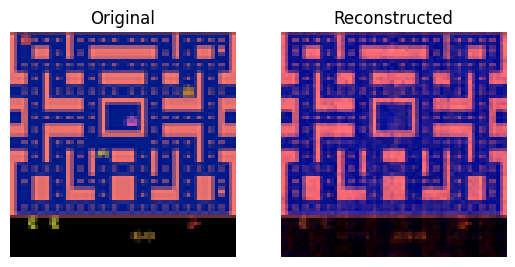

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


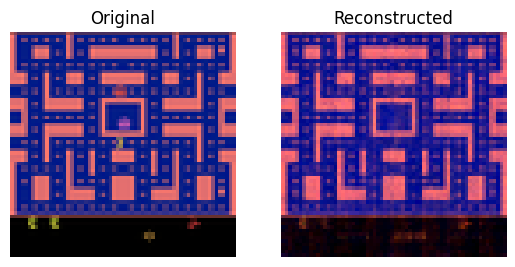

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


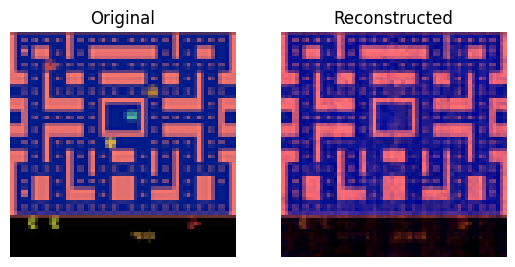

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


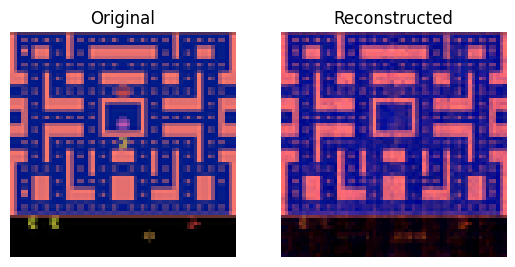

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


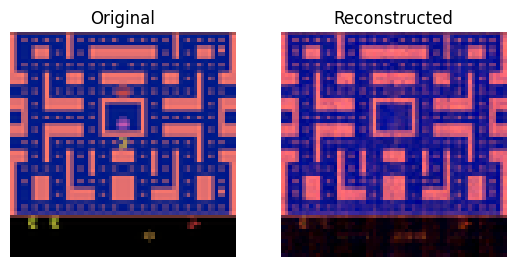

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


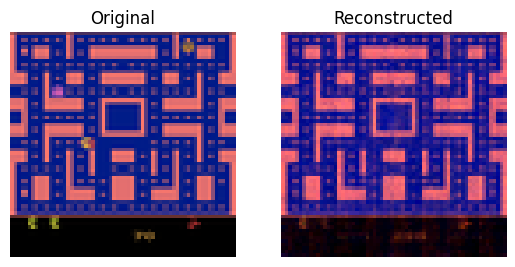

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


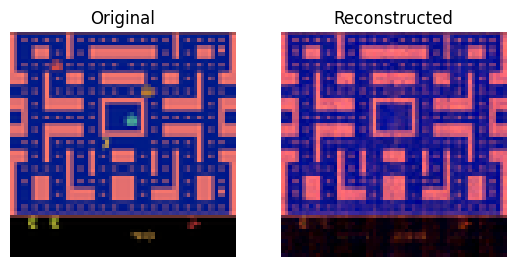

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


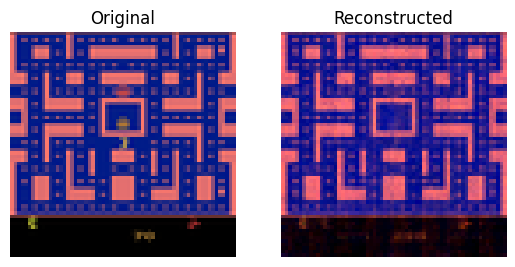

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


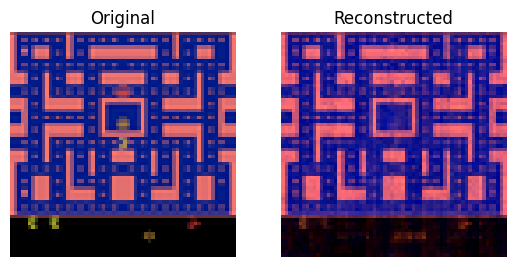

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


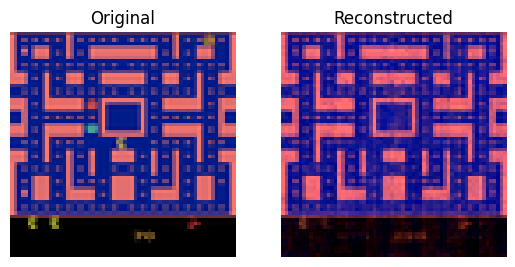

In [21]:
eval_vqvae(vqvae, shuffled_train_dataset)